# RLCT Estimation of MNIST

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/mnist.ipynb)

This Jupyter Notebook aims to reproduce the results of Lau et al. (2023) by measuring the Real Log Canonical Threshold (RLCT) for a small 2-layer ReLU model (about 1M parameters) trained on the MNIST dataset. It uses both Stochastic Gradient Nose-Hoover Thermostat (SGNHT) and Stochastic Gradient Langevin Dynamics (SGLD) as sampling methods.

## Main Steps:

1. **Data Preparation**: Load the MNIST dataset for training and testing.
2. **Model Training**: Train a multi-layer perceptron model using stochastic gradient descent.
3. **Model Evaluation**: Evaluate the model's performance on a test set.
4. **RLCT Estimation**: Use SGNHT and SGLD samplers to estimate RLCT.
5. **Plotting**: Visualize train and test losses, and RLCT estimates.

In [1]:
%pip install --upgrade pip
%pip install transformers torch torchvision seaborn
%pip install devinterp

!git clone https://github.com/ucla-vision/entropy-sgd.git
%cd entropy-sgd
from python.optim import EntropySGD  
%cd ..



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Cloning into 'entropy-sgd'...
remote: Enumerating objects: 89, done.
remote: Total 89 (delta 0), reused 0 (delta 0), pack-reused 89 (from 1)
Unpacking objects: 100% (89/89), 25.31 KiB | 1.41 MiB/s, done.
/home/paperspace/devinterp/examples/entropy-sgd
/home/paperspace/devinterp/examples


In [2]:
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PRIMARY, SECONDARY, TERTIARY, QUATERNARY = sns.color_palette("muted")[:4]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT, QUATERNARY_LIGHT = sns.color_palette(
    "pastel"
)[:4]

In [3]:
def emtpy_func():
    return (), ()


def train_one_epoch(model, train_loader, optimizer, criterion, model_key):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        if model_key == "sgd":
            optimizer.step()
        else:
            optimizer.step(emtpy_func, model, criterion)
    return train_loss / len(train_loader)


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)


# Define the neural network
class Net(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes=[1024, 1024],
        input_dim=28 * 28,
        output_dim=10,
        activation=F.relu,
        with_bias=True,
    ):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
        self.activation = activation
        self.with_bias = with_bias
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            dim_in, dim_out = self.layer_sizes[i : i + 2]
            self.layers.append(nn.Linear(dim_in, dim_out, bias=self.with_bias).float())

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

In [4]:
# Constants
DEVICE = "cpu"
BATCH_SIZE = 512
LR = 0.05
MOMENTUM = 0.9
N_EPOCHS = 10
DATA_PATH = "../data"


# Load MNIST dataset
def load_mnist_data(train, batch_size, shuffle):
    dataset = datasets.MNIST(
        DATA_PATH, train=train, transform=transforms.ToTensor(), download=True
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


train_loader = load_mnist_data(train=True, batch_size=BATCH_SIZE, shuffle=True)
test_loader = load_mnist_data(train=False, batch_size=BATCH_SIZE, shuffle=False)

model_esgd = Net().to(DEVICE)
model_sgd = Net().to(DEVICE)
optimizer_esgd = EntropySGD(
    model_esgd.parameters(), config=dict(lr=LR, momentum=MOMENTUM, L=5)
)
optimizer_sgd = optim.SGD(
    model_sgd.parameters(), lr=LR, momentum=MOMENTUM, nesterov=True
)

criterion = nn.CrossEntropyLoss()

In [5]:
train_losses, test_losses, models_saved = {}, {}, {}
for model_key, model, optimizer in [
    ("esgd", model_esgd, optimizer_esgd),
    ("sgd", model_sgd, optimizer_sgd),
]:
    train_losses[model_key] = []
    test_losses[model_key] = []
    models_saved[model_key] = []

    for epoch in range(N_EPOCHS):
        train_loss = train_one_epoch(
            model, train_loader, optimizer, criterion, model_key
        )
        test_loss = evaluate(model, test_loader, criterion)
        train_losses[model_key].append(train_loss)
        test_losses[model_key].append(test_loss)
        models_saved[model_key] += [copy.deepcopy(model)]

        print(
            f"Epoch {epoch+1}, Model {model_key.upper()} Train Loss: {train_loss}, Test Loss: {test_loss}"
        )

  0%|          | 0/118 [00:00<?, ?it/s]/home/svwin/devinterp/examples/entropy-sgd/python/optim.py:72: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1630.)
  mdw.mul_(mom).add_(1-damp, dw)
100%|██████████| 118/118 [00:31<00:00,  3.70it/s]


Epoch 1, Model ESGD Train Loss: 0.520543460181709, Test Loss: 0.14373821429908276


100%|██████████| 118/118 [00:25<00:00,  4.56it/s]


Epoch 2, Model ESGD Train Loss: 0.10414145050286236, Test Loss: 0.10481228260323405


100%|██████████| 118/118 [00:25<00:00,  4.58it/s]


Epoch 3, Model ESGD Train Loss: 0.06439691013261928, Test Loss: 0.07769402964040636


100%|██████████| 118/118 [00:27<00:00,  4.37it/s]


Epoch 4, Model ESGD Train Loss: 0.043287328249080326, Test Loss: 0.0634560571052134


100%|██████████| 118/118 [00:25<00:00,  4.61it/s]


Epoch 5, Model ESGD Train Loss: 0.02971772437074648, Test Loss: 0.0651294318959117


100%|██████████| 118/118 [00:25<00:00,  4.66it/s]


Epoch 6, Model ESGD Train Loss: 0.021006646317477198, Test Loss: 0.06795943402685226


100%|██████████| 118/118 [00:25<00:00,  4.70it/s]


Epoch 7, Model ESGD Train Loss: 0.015240220003761351, Test Loss: 0.07017610149923711


100%|██████████| 118/118 [00:25<00:00,  4.68it/s]


Epoch 8, Model ESGD Train Loss: 0.010381115683338653, Test Loss: 0.07317977137863636


100%|██████████| 118/118 [00:25<00:00,  4.58it/s]


Epoch 9, Model ESGD Train Loss: 0.00836867772011181, Test Loss: 0.06080201299628243


100%|██████████| 118/118 [00:26<00:00,  4.53it/s]


Epoch 10, Model ESGD Train Loss: 0.005955816361011337, Test Loss: 0.06499954364262521


100%|██████████| 118/118 [00:11<00:00, 10.50it/s]


Epoch 1, Model SGD Train Loss: 0.7046918516694489, Test Loss: 0.2804649993777275


100%|██████████| 118/118 [00:11<00:00, 10.63it/s]


Epoch 2, Model SGD Train Loss: 0.23119064193155806, Test Loss: 0.2077132284641266


100%|██████████| 118/118 [00:11<00:00, 10.49it/s]


Epoch 3, Model SGD Train Loss: 0.1623564348003622, Test Loss: 0.15121494550257922


100%|██████████| 118/118 [00:11<00:00, 10.70it/s]


Epoch 4, Model SGD Train Loss: 0.12224109701307143, Test Loss: 0.12011358859017492


100%|██████████| 118/118 [00:10<00:00, 10.98it/s]


Epoch 5, Model SGD Train Loss: 0.09519002580289114, Test Loss: 0.10901108467951418


100%|██████████| 118/118 [00:11<00:00, 10.66it/s]


Epoch 6, Model SGD Train Loss: 0.07665509379358362, Test Loss: 0.08917208248749375


100%|██████████| 118/118 [00:11<00:00, 10.47it/s]


Epoch 7, Model SGD Train Loss: 0.06297573845012713, Test Loss: 0.0825060684233904


100%|██████████| 118/118 [00:10<00:00, 10.79it/s]


Epoch 8, Model SGD Train Loss: 0.05249734841665979, Test Loss: 0.07756000394001603


100%|██████████| 118/118 [00:10<00:00, 10.79it/s]


Epoch 9, Model SGD Train Loss: 0.0446294730024065, Test Loss: 0.06989156450144947


100%|██████████| 118/118 [00:11<00:00, 10.54it/s]


Epoch 10, Model SGD Train Loss: 0.03807993709914765, Test Loss: 0.07223279816098511


In [6]:
from devinterp.slt.sampler import estimate_learning_coeff
from devinterp.utils import evaluate_ce


def estimate_rlcts(models, train_loader, device):
    estimates = {"sgnht": [], "sgld": []}
    for model in tqdm(models):
        for method, optimizer_kwargs in [
            ("sgnht", {"lr": 1e-7, "diffusion_factor": 0.01}),
            ("sgld", {"lr": 1e-5, "localization": 100.0}),
        ]:
            estimate = estimate_learning_coeff(
                model,
                train_loader,
                evaluate=evaluate_ce,
                optimizer_kwargs=optimizer_kwargs,
                sampling_method=SGNHT if method == "sgnht" else SGLD,
                num_chains=1,
                num_draws=400,
                num_burnin_steps=0,
                num_steps_bw_draws=1,
                device=device,
                verbose=False,
            )
            estimates[method].append(estimate)
    return estimates


data_length = len(train_loader.dataset)
rlct_esgd = estimate_rlcts(models_saved["esgd"], train_loader, DEVICE)
rlct_sgd = estimate_rlcts(models_saved["sgd"], train_loader, DEVICE)

  0%|          | 0/10 [00:00<?, ?it/s]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


/home/paperspace/devinterp/src/devinterp/backends/default/slt/sampler.py:208: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/paperspace/devinterp/src/devinterp/backends/default/slt/sampler.py:212: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
/home/paperspace/devinterp/src/devinterp/backends/default/slt/sampler.py:52: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


 10%|█         | 1/10 [00:48<07:16, 48.55s/it]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


 20%|██        | 2/10 [01:36<06:27, 48.47s/it]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


 30%|███       | 3/10 [02:25<05:39, 48.51s/it]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


 40%|████      | 4/10 [03:13<04:49, 48.27s/it]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


 50%|█████     | 5/10 [04:02<04:02, 48.45s/it]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


 60%|██████    | 6/10 [04:50<03:13, 48.42s/it]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


 70%|███████   | 7/10 [05:39<02:25, 48.64s/it]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


 80%|████████  | 8/10 [06:26<01:36, 48.21s/it]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


 90%|█████████ | 9/10 [07:16<00:48, 48.66s/it]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


  0%|          | 0/10 [00:00<?, ?it/s]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


 10%|█         | 1/10 [00:47<07:09, 47.78s/it]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


 20%|██        | 2/10 [01:35<06:22, 47.82s/it]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


 30%|███       | 3/10 [02:24<05:36, 48.11s/it]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


 40%|████      | 4/10 [03:12<04:48, 48.04s/it]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


 50%|█████     | 5/10 [03:59<04:00, 48.01s/it]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


 60%|██████    | 6/10 [04:49<03:13, 48.42s/it]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


 70%|███████   | 7/10 [05:37<02:25, 48.35s/it]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


 80%|████████  | 8/10 [06:26<01:36, 48.43s/it]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


 90%|█████████ | 9/10 [07:14<00:48, 48.38s/it]

nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
nbeta not set - using default nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


100%|██████████| 10/10 [08:03<00:00, 48.31s/it]


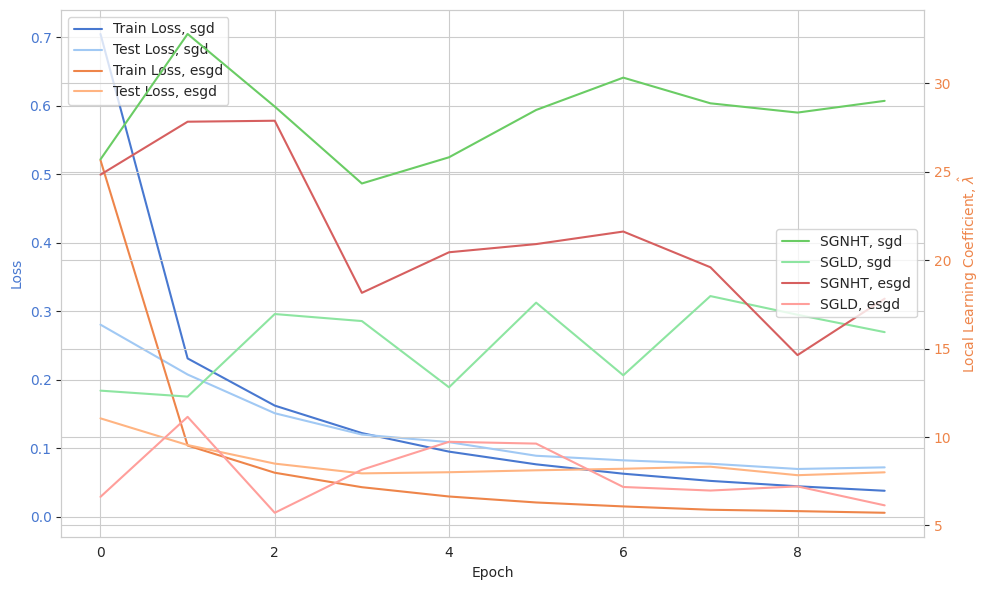

In [7]:
sns.set_style("whitegrid")

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=PRIMARY)
ax1.plot(train_losses["sgd"], label="Train Loss, sgd", color=PRIMARY)
ax1.plot(test_losses["sgd"], label="Test Loss, sgd", color=PRIMARY_LIGHT)

ax1.plot(train_losses["esgd"], label="Train Loss, esgd", color=SECONDARY)
ax1.plot(test_losses["esgd"], label="Test Loss, esgd", color=SECONDARY_LIGHT)
ax1.tick_params(axis="y", labelcolor=PRIMARY)
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.set_ylabel(r"Local Learning Coefficient, $\hat \lambda$", color=SECONDARY)
ax2.plot(rlct_sgd["sgnht"], label="SGNHT, sgd", color=TERTIARY)
ax2.plot(rlct_sgd["sgld"], label="SGLD, sgd", color=TERTIARY_LIGHT)

ax2.plot(rlct_esgd["sgnht"], label="SGNHT, esgd", color=QUATERNARY)
ax2.plot(rlct_esgd["sgld"], label="SGLD, esgd", color=QUATERNARY_LIGHT)
ax2.tick_params(axis="y", labelcolor=SECONDARY)
ax2.legend(loc="center right")

fig.tight_layout()
plt.show()